## Inject Bugs & Run Experiment

![Inject Bugs & Run Experiment](./pic/RL_Testing.drawio.png)

#### Frozenlake Testbed Experiment

- Find log files in RLTestig/logs/frozenlake

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [0],
    [1],
    [2],
    [3],
    [4],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15],
]

bug_version = []


In [ ]:
BL.cover_then_inject_bugs(bug_version)
# After this step, Restart the ipynb environment

In [ ]:
import frozenlake.testing_SB3_Frozenlake as Frozenlake_Experiment
Frozenlake_Experiment.main(bug_version=bug_version, rounds=10, epochs=300, model_type='ppo')

#### Mountaincar Testbed (continous) Experiment

- Find log files in RLTestig/logs/mountaincar

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [5],
    [6],
    [7],
    [8],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15]
]

bug_version = []

In [ ]:
BL.cover_then_inject_bugs(bug_version)

In [ ]:
import mountaincar.testing_SB3_Mountaincar as Mountaincar_Experiment


Mountaincar_Experiment.main(bug_version=bug_version, rounds=10, epochs=300, model_type='sac')

## Validation Part

In [58]:
import log_parser
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import config_parser
from scipy.stats import binomtest


root_dir = config_parser.parserConfig()['root_dir']


import pandas as pd
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_with_convergence_slop_check(data, title='Data Trend Analysis', window_size=5, threshold_slope=0, show=False):
    
    series = pd.Series(data)

    # 计算标准差的移动平均
    rolling_std = series.rolling(window=window_size).std().dropna()

    # 使用线性回归判断移动标准差的趋势
    std_slope, std_intercept, _, _, _ = linregress(range(len(rolling_std)), rolling_std)

    # 使用线性回归判断原始数据的趋势
    slope, intercept, _, _, _ = linregress(range(len(data)), data)
    
    if show:
        plt.figure(figsize=(12, 6))
        
        # 绘制原始数据和趋势线
        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', marker='o')
        plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
        plt.legend()
        plt.title(title)
        
        # 绘制移动标准差和其趋势线
        plt.subplot(1, 2, 2)
        plt.plot(rolling_std.index, rolling_std, label='Moving Standard Deviation', marker='o')
        plt.plot(rolling_std.index, std_intercept + std_slope * np.asarray(range(len(rolling_std))), 'g', label=f'STD Trend Line: slope={std_slope:.2f}')
        plt.axhline(y=0, color='r', linestyle='--', label='Zero Slope Reference')
        plt.legend()
        plt.title('Standard Deviation Trend Analysis')
        
        plt.tight_layout()
        plt.show()

    # 判断标准差的趋势是否为负，并且原始数据的趋势是否为正
    if slope >= 0 and std_slope <= threshold_slope:
        return "true"
    else:
        return "false"


def linear_regression_with_convergence_check(data, title='Data Trend Analysis', window_size=5, threshold=0.05, show=False):
    
    # 将数据转换成Pandas Series对象
    series = pd.Series(data)

    # 计算标准差的移动平均
    rolling_std = series.rolling(window=window_size).std()

    # 判断最后一个窗口的标准差是否小于阈值，确定是否收敛
    is_converged = rolling_std.iloc[-1] < threshold

    # 使用线性回归判断趋势
    slope, intercept, r_value, p_value, std_err = linregress(range(len(data)), data)
    
    if show:
        # 绘制数据和趋势线以及移动标准差
        plt.figure(figsize=(12, 6))
        
        # 绘制原始数据和趋势线
        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', marker='o')
        plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
        plt.legend()
        plt.title(title)
        
        # 绘制移动标准差
        plt.subplot(1, 2, 2)
        plt.plot(rolling_std, label='Moving Standard Deviation')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
        plt.legend()
        plt.title('Data Convergence Check')
        
        plt.tight_layout()
        plt.show()

    # 如果斜率大于或等于0，并且数据收敛，则返回True
    if slope < 0 or not is_converged:
        return "false"
    else:
        return "true"


# def linelar_regression(data, title = 'Data Trend Analysis', show=False):

#     # 将数据转换成Pandas Series对象
#     series = pd.Series(data)

#     # 计算简单移动平均(SMA)和指数移动平均(EMA)
#     sma = series.rolling(window=3).mean()
#     ema = series.ewm(span=3, adjust=False).mean()

#     # 使用线性回归判断趋势
#     slope, intercept, r_value, p_value, std_err = linregress(range(len(data)), data)
    
#     if show:
#         # 绘制数据和趋势线
#         plt.figure(figsize=(12, 6))
#         plt.plot(data, label='Original Data', marker='o')
#         plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
#         plt.legend()
#         plt.title(title)
#         plt.show()

#     # 输出线性回归结果
#     # print(f"Slope of trend line: {slope:.2f}")

#     # 如果斜率显著小于0，我们可以认为不存在上升趋势
#     if slope < 0:
#         return 'false'
#     else:
#         return 'true'
    

def test_true_proportion(num_samples, num_true, sig_level=0.05, expected_prob=0.95):
    """
    对观察到的 'true' 样本数进行二项检验。

    :param num_samples: 样本总数
    :param num_true: 观察到的 'true' 样本数
    :param sig_level: 显著性水平（默认为 0.05）
    :param expected_prob: 预期成功概率（默认为 0.5）
    :return: p 值和是否显著
    """
    # 计算二项检验的 p 值
    p_value = binomtest(k=num_true, n=num_samples, p=expected_prob, alternative='greater')

    # 判断是否显著
    is_significant = p_value < sig_level

    return p_value, is_significant


def bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]
    print(bug_free_log_list)

    result = []
    for path in bug_free_log_list:
        # print(log_parser.parse_log_file(path))
        data = log_parser.parse_log_file_fuzzy(path)
        if len(data)> 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            temp = linear_regression_with_convergence_check(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
        result.append(temp)

    p_value = binomtest(result.count('true'), len(result), alternative='greater')
    print(p_value)

    
def bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]

    print(bug_free_log_list)

    # accuracy_list = []
    # 打印所有文件路径
    result = []
    for path in bug_free_log_list:
        data = log_parser.parse_mountaincar_log_file(path)
        if len(data) > 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
        result.append(temp)
    
    
    '''
    在进行二项检验时，零假设（null hypothesis）通常是观察到的成功次数与随机变化相一致，即成功的概率等于 expected_prob。如果实际观察到的成功次数显著高于（或低于）这个期望成功概率，那么您可能会得到一个很小的 p 值，从而拒绝零假设。
    '''
    p_value = binomtest(result.count('true'), len(result), alternative='greater')
    print(p_value)

[WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_0'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_1'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_2'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_3'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_4'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_5'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_6'), WindowsPath('C:/Users/iansy/Documents/GitHub/RL-testing-new/RLTesting/logs/Frozenlake/a2c/[25]/time_2024-03-11[25]round_7'),

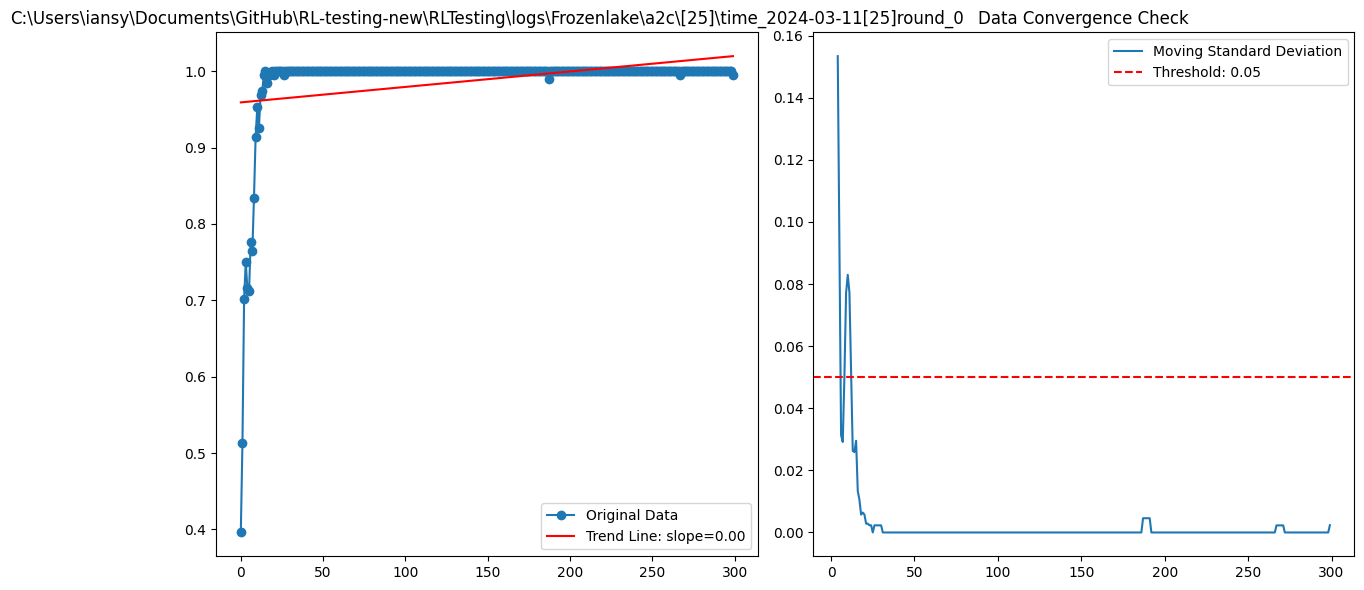

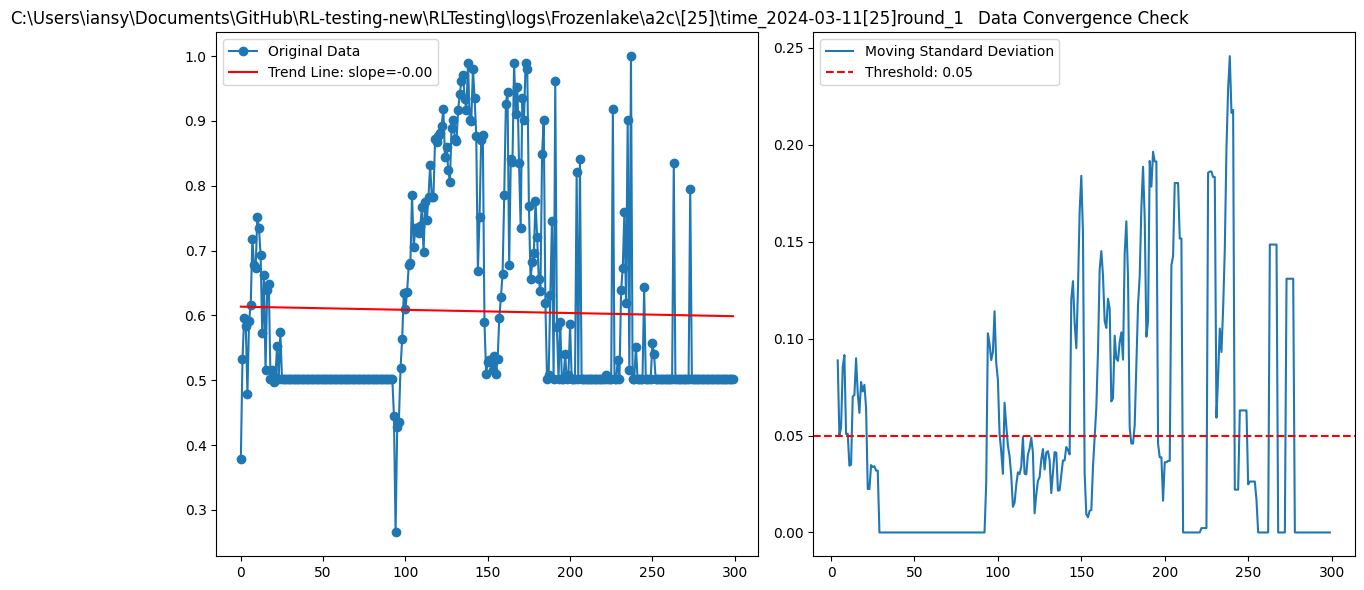

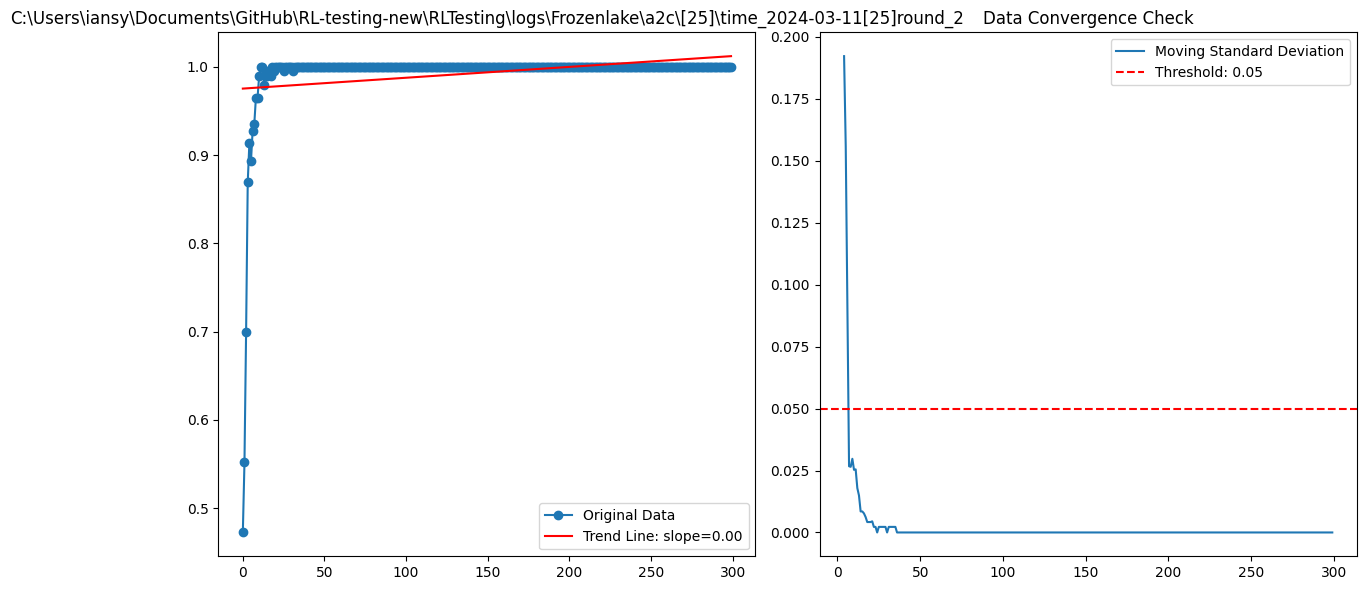

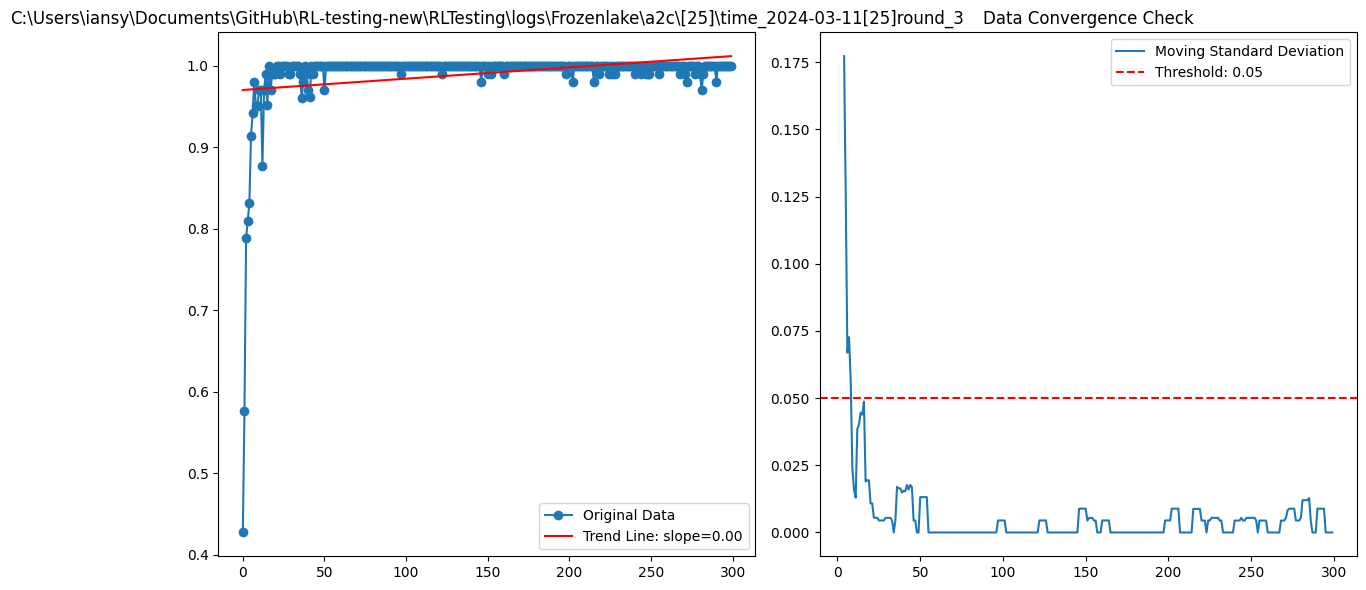

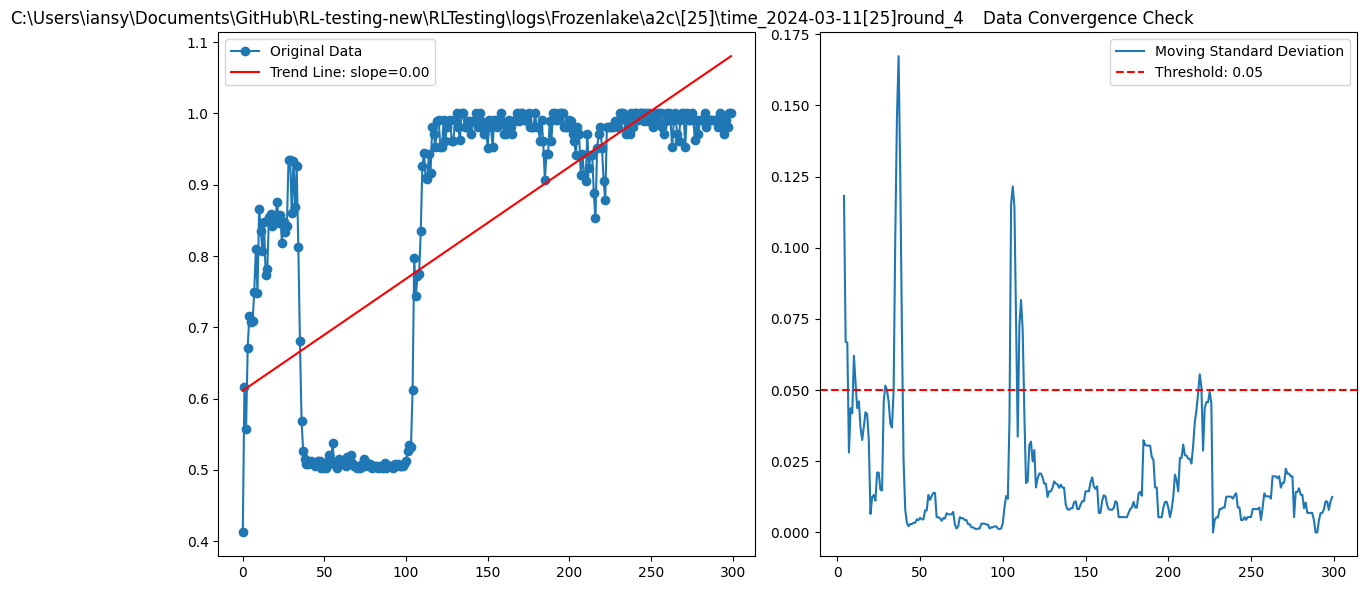

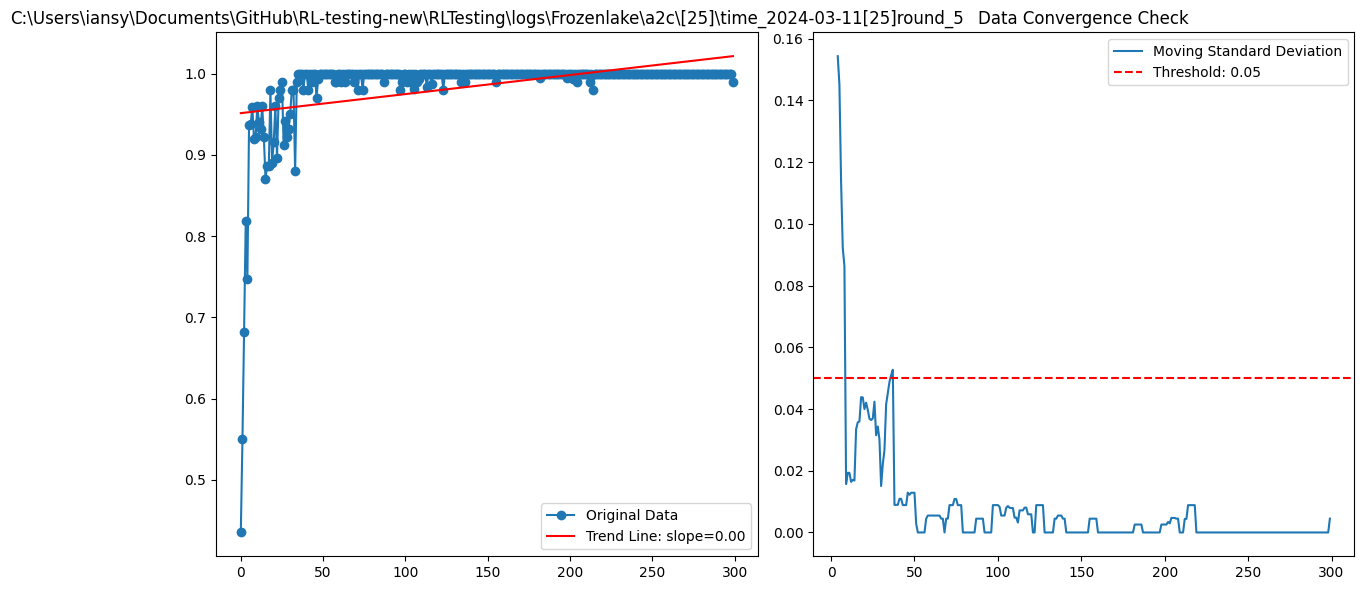

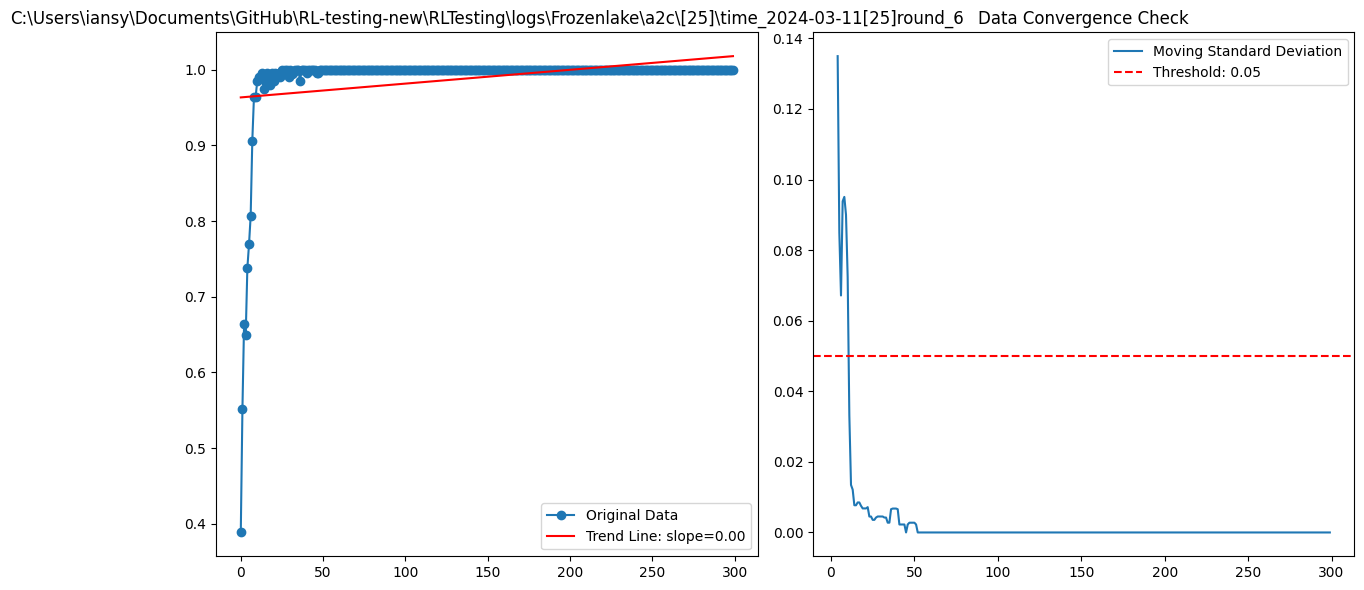

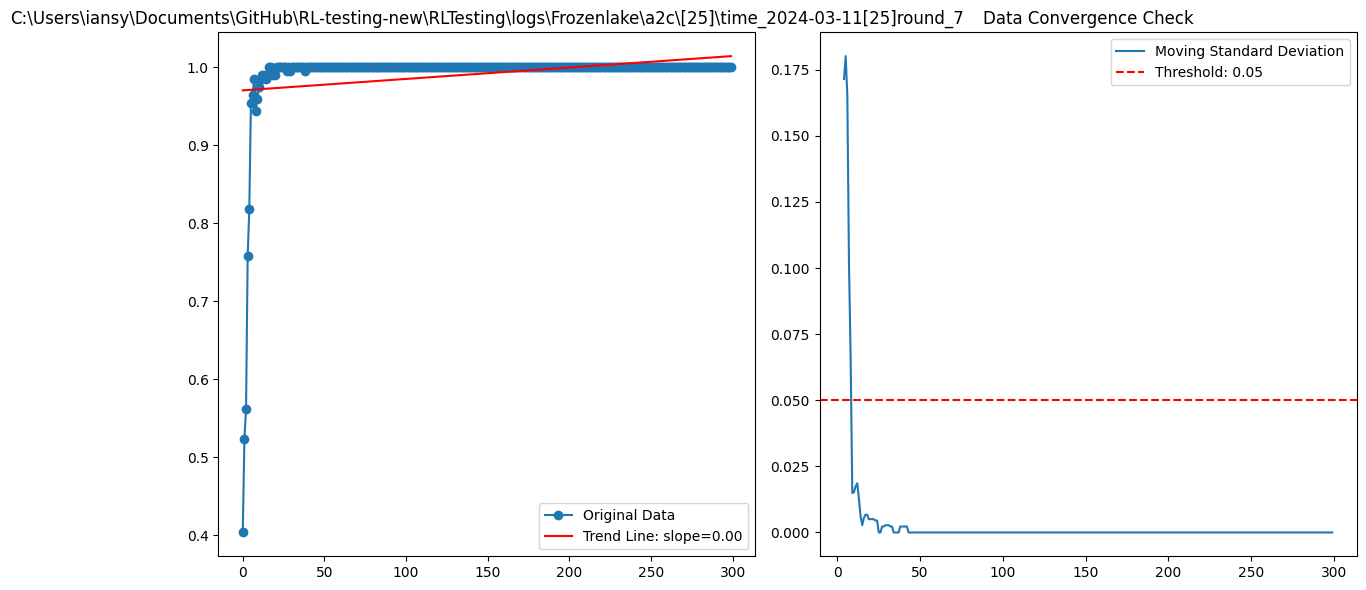

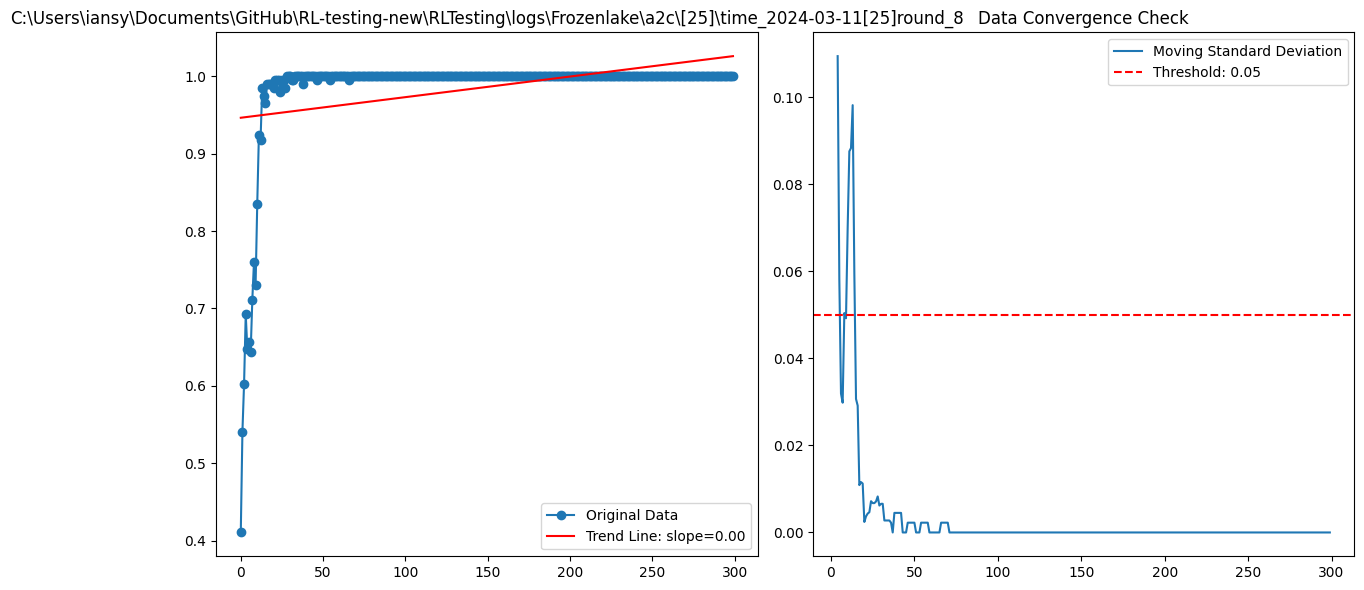

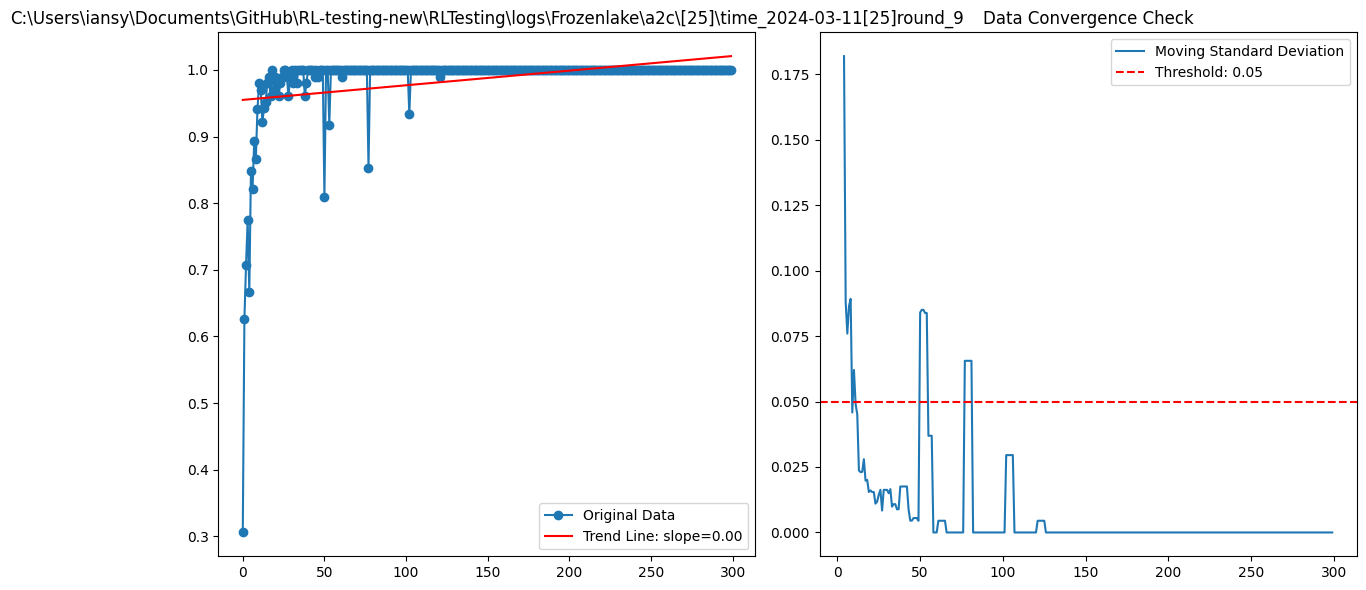

BinomTestResult(k=9, n=10, alternative='greater', statistic=0.9, pvalue=0.0107421875)


In [59]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_2sdffig=True)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[25]')), show_fig=True)